# Importing

In [116]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn_som.som import SOM
import salishsea_tools.viz_tools as sa_vi


# Datasets Preparation

In [117]:
def datasets_preparation():
    
    ds = xr.open_dataset ('/results2/SalishSea/nowcast-green.202111/31mar22/SalishSea_1d_20220331_20220331_grid_T.nc')
    ds_bio = xr. open_dataset ('/results2/SalishSea/nowcast-green.202111/31mar22/SalishSea_1d_20220331_20220331_biol_T.nc')

    # Variable selection
    temp = ds.votemper
    saline = ds.vosaline
    date = pd.DatetimeIndex(ds['time_counter'].values)

    # Biological variables
    sil = ds_bio.silicon
    flag = ds_bio.flagellates
    diat = ds_bio.diatoms

    # Open the mesh mask
    mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
    mask = mesh.tmask.to_numpy()
    
    return (ds, temp, saline, date, mask, sil, flag, diat)


# Masking

In [118]:
def masking (depth, temp, saline, mask, sil, flag, diat):

    temp = temp.where(mask[0,depth]==1)
    saline = saline.where(mask[0,depth]==1)

    sil = sil.where(mask[0,depth]==1)
    flag = flag.where(mask[0,depth]==1)
    diat = diat.where(mask[0,depth]==1)

    return (temp, saline, sil, flag, diat)

# SOM

In [119]:
def som (depth, temp, saline):
    
    # Post processing 
    inputs = np.stack((temp[0,depth].values.flatten(), saline[0,depth].values.flatten()))
    indx = np.argwhere(~np.isnan(inputs[0]) & ~np.isnan(inputs[1])) 
    inputs2 = np.transpose(inputs)  
    inputs2 = inputs2[indx[:,0]]

    # SOM
    temp_som = SOM(m=2, n=3, dim= inputs2[0,:].size)
    temp_som.fit(inputs2)
    predictions = temp_som.predict(inputs2)

    # Post processing
    unique, counts = np.unique(predictions, return_counts=True)
    indx2 = np.full(inputs[0,:].size,np.nan)
    indx2[indx[:,0]] = predictions
    clusters = np.reshape(indx2,(898,398))   

    return (unique, counts, inputs2, predictions, clusters)


# Printing

In [120]:
def printing (inputs, predictions, unique, counts):

    # Preparation of the dataframe
    d = {'temperature': inputs[:,0], 'salinity': inputs[:,1], 'cluster': predictions}
    df = pd.DataFrame(d) 

    # Calculating the metrics
    mean_temp = np.round(df.groupby('cluster')['temperature'].mean(), 2)
    mean_sal = np.round(df.groupby('cluster')['salinity'].mean(), 2)
    min_temp = np.round(df.groupby('cluster')['temperature'].min(), 2)
    max_temp = np.round(df.groupby('cluster')['temperature'].max(), 2)
    min_sal = np.round(df.groupby('cluster')['salinity'].min(), 2)
    max_sal = np.round(df.groupby('cluster')['salinity'].max(), 2)

    # Printing
    for i in unique:
            print('The amount of grid boxes for cluster ' + str(i), 'is ' + str(counts[i]), '\n')

            print ('The minimum temperature for cluster '+ str(i), 'is ' + str(min_temp[i]), 'degrees Celsius')
            print ('The maximum temperature for cluster '+ str(i), 'is ' + str(max_temp[i]), 'degrees Celsius')
            print ('The mean temperature for cluster '+ str(i), 'is ' + str(mean_temp[i]), 'degrees Celsius', '\n')

            print ('The minimum salinity for cluster '+ str(i), 'is ' + str(min_sal[i]), 'g/kg')
            print ('The maximum salinity for cluster '+ str(i), 'is ' + str(max_sal[i]), 'g/kg')
            print ('The mean salinity for cluster '+ str(i), 'is ' + str(mean_sal[i]), 'g/kg', '\n'*2)
        

# Plotting

In [121]:
def plotting (depth, clusters, unique, sil, flag, diat):

    # Preparation of the dataarray 
    map = xr.DataArray(clusters,
                    coords = {'y': temp[0,depth].y, 'x': temp[0,depth].x},
                    dims = ['y','x'],
                    attrs=dict(description="Clusters of the performed self organizing map algorithm",
                                long_name ="Cluster",
                                units="count"),
                    ) 

    fig, ax = plt.subplots(2,2, figsize=(15, 5))

    cmap = plt.get_cmap('viridis', unique.max()+1)
    cmap.set_bad('gray')


    map.plot.pcolormesh(ax=ax[0,0], cmap=cmap, levels= np.concatenate((unique,[unique.size])), cbar_kwargs={'ticks': unique})
    
    cmap = plt.get_cmap('turbo')
    cmap.set_bad('gray')
    sil[0,depth].plot.pcolormesh(ax=ax[0,1], cmap=cmap) 
    flag[0,depth].plot.pcolormesh(ax=ax[1,0], cmap=cmap) 
    diat[0,depth].plot.pcolormesh(ax=ax[1,1], cmap=cmap) 

    sa_vi.set_aspect(ax[0,0])
    sa_vi.set_aspect(ax[0,1])
    sa_vi.set_aspect(ax[1,0])
    sa_vi.set_aspect(ax[1,1])

    ax[0,0].title.set_text('Clustering')
    ax[0,1].title.set_text('Silicones')
    ax[1,0].title.set_text('Flaggelates')
    ax[1,1].title.set_text('Diatoms')

    if date[0].month < 10:
        month = '0' + str(date[0].month)
    else:
        month = str(date[0].month)

    if date[0].day < 10:
        day = '0' + str(date[0].day)  
    else:
        day = str(date[0].day) 

    fig.suptitle('Depth: ' + str(np.round(ds['deptht'][depth].values,2)) + ' meters ,' + str(date[0].year) + '/' + month + '/' + day)
    plt.show()


# Main FOR Loop From Where All Functions are Called

The amount of grid boxes for cluster 0 is 12244 

The minimum temperature for cluster 0 is 6.25 degrees Celsius
The maximum temperature for cluster 0 is 11.04 degrees Celsius
The mean temperature for cluster 0 is 9.02 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 23.04 g/kg
The mean salinity for cluster 0 is 17.69 g/kg 


The amount of grid boxes for cluster 1 is 12936 

The minimum temperature for cluster 1 is 7.38 degrees Celsius
The maximum temperature for cluster 1 is 10.53 degrees Celsius
The mean temperature for cluster 1 is 9.02 degrees Celsius 

The minimum salinity for cluster 1 is 24.81 g/kg
The maximum salinity for cluster 1 is 26.83 g/kg
The mean salinity for cluster 1 is 25.97 g/kg 


The amount of grid boxes for cluster 2 is 11567 

The minimum temperature for cluster 2 is 7.18 degrees Celsius
The maximum temperature for cluster 2 is 9.85 degrees Celsius
The mean temperature for cluster 2 is 8.52 degrees Celsius 

T

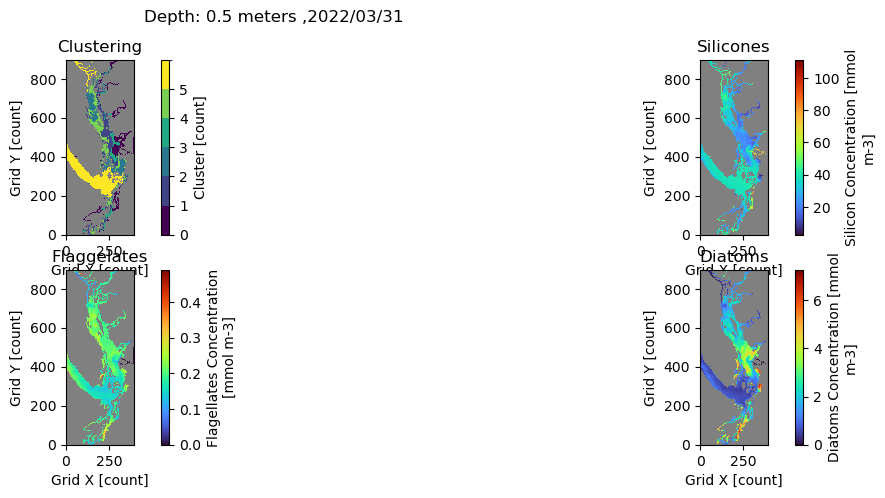

The amount of grid boxes for cluster 0 is 26746 

The minimum temperature for cluster 0 is 6.72 degrees Celsius
The maximum temperature for cluster 0 is 9.72 degrees Celsius
The mean temperature for cluster 0 is 7.99 degrees Celsius 

The minimum salinity for cluster 0 is 28.85 g/kg
The maximum salinity for cluster 0 is 31.32 g/kg
The mean salinity for cluster 0 is 30.35 g/kg 


The amount of grid boxes for cluster 1 is 7511 

The minimum temperature for cluster 1 is 7.42 degrees Celsius
The maximum temperature for cluster 1 is 9.71 degrees Celsius
The mean temperature for cluster 1 is 8.61 degrees Celsius 

The minimum salinity for cluster 1 is 26.34 g/kg
The maximum salinity for cluster 1 is 27.96 g/kg
The mean salinity for cluster 1 is 27.49 g/kg 


The amount of grid boxes for cluster 2 is 11498 

The minimum temperature for cluster 2 is 6.25 degrees Celsius
The maximum temperature for cluster 2 is 11.16 degrees Celsius
The mean temperature for cluster 2 is 9.11 degrees Celsius 

T

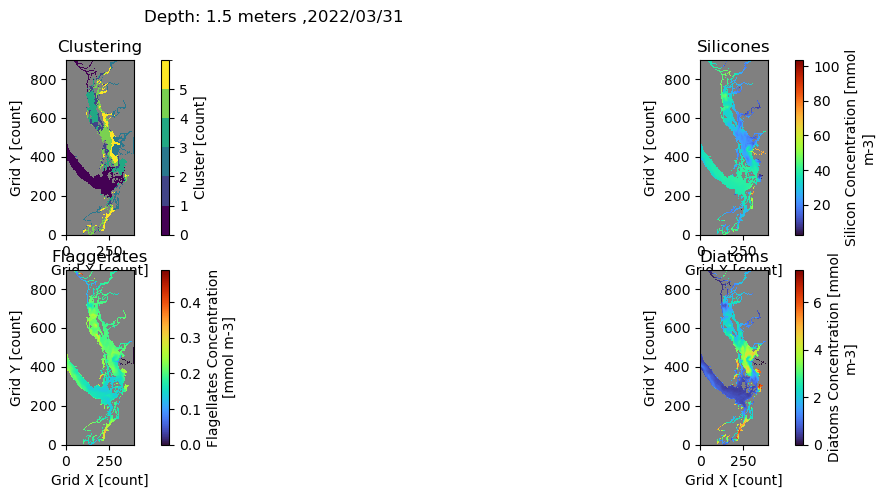

The amount of grid boxes for cluster 0 is 9069 

The minimum temperature for cluster 0 is 7.0 degrees Celsius
The maximum temperature for cluster 0 is 9.58 degrees Celsius
The mean temperature for cluster 0 is 8.33 degrees Celsius 

The minimum salinity for cluster 0 is 28.3 g/kg
The maximum salinity for cluster 0 is 29.43 g/kg
The mean salinity for cluster 0 is 28.84 g/kg 


The amount of grid boxes for cluster 1 is 15210 

The minimum temperature for cluster 1 is 7.48 degrees Celsius
The maximum temperature for cluster 1 is 10.14 degrees Celsius
The mean temperature for cluster 1 is 8.75 degrees Celsius 

The minimum salinity for cluster 1 is 25.72 g/kg
The maximum salinity for cluster 1 is 27.43 g/kg
The mean salinity for cluster 1 is 26.67 g/kg 


The amount of grid boxes for cluster 2 is 10582 

The minimum temperature for cluster 2 is 6.25 degrees Celsius
The maximum temperature for cluster 2 is 11.12 degrees Celsius
The mean temperature for cluster 2 is 9.04 degrees Celsius 

Th

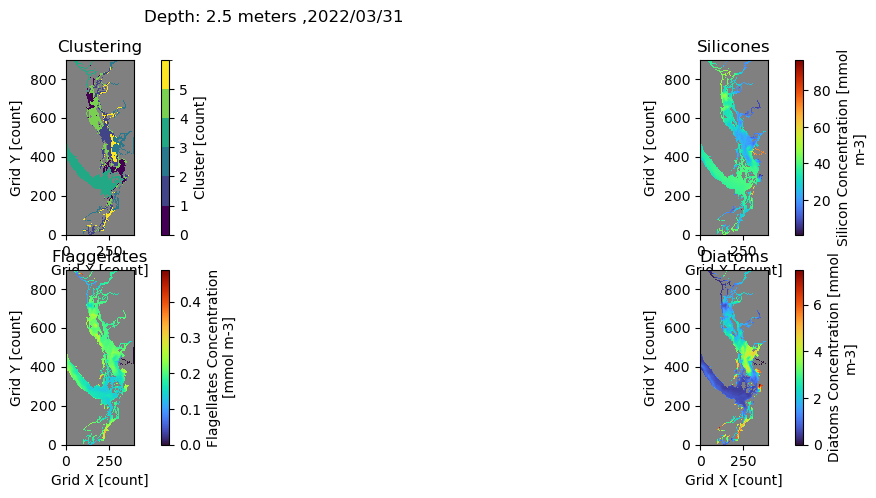

The amount of grid boxes for cluster 0 is 9566 

The minimum temperature for cluster 0 is 6.8 degrees Celsius
The maximum temperature for cluster 0 is 9.53 degrees Celsius
The mean temperature for cluster 0 is 8.28 degrees Celsius 

The minimum salinity for cluster 0 is 28.52 g/kg
The maximum salinity for cluster 0 is 29.67 g/kg
The mean salinity for cluster 0 is 28.98 g/kg 


The amount of grid boxes for cluster 1 is 15487 

The minimum temperature for cluster 1 is 7.43 degrees Celsius
The maximum temperature for cluster 1 is 10.26 degrees Celsius
The mean temperature for cluster 1 is 8.52 degrees Celsius 

The minimum salinity for cluster 1 is 26.46 g/kg
The maximum salinity for cluster 1 is 28.05 g/kg
The mean salinity for cluster 1 is 27.2 g/kg 


The amount of grid boxes for cluster 2 is 9515 

The minimum temperature for cluster 2 is 7.45 degrees Celsius
The maximum temperature for cluster 2 is 10.4 degrees Celsius
The mean temperature for cluster 2 is 8.86 degrees Celsius 

The 

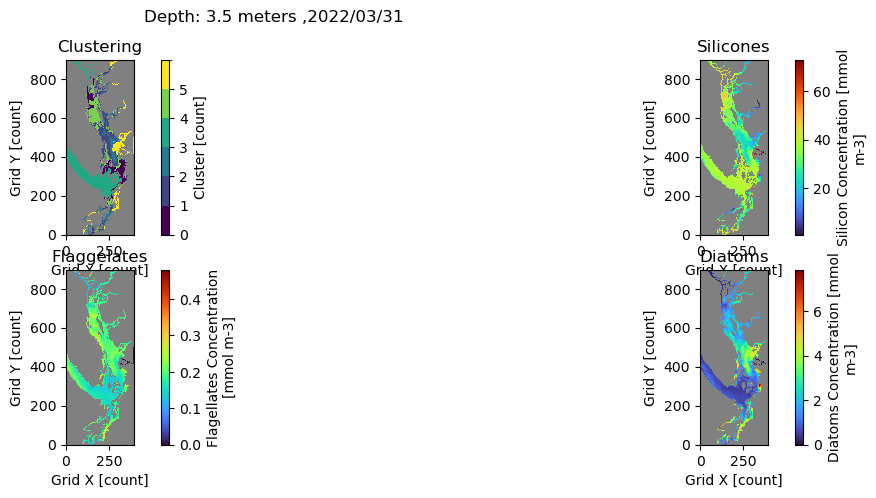

The amount of grid boxes for cluster 0 is 14983 

The minimum temperature for cluster 0 is 7.32 degrees Celsius
The maximum temperature for cluster 0 is 10.24 degrees Celsius
The mean temperature for cluster 0 is 8.5 degrees Celsius 

The minimum salinity for cluster 0 is 26.4 g/kg
The maximum salinity for cluster 0 is 27.92 g/kg
The mean salinity for cluster 0 is 27.12 g/kg 


The amount of grid boxes for cluster 1 is 15762 

The minimum temperature for cluster 1 is 7.41 degrees Celsius
The maximum temperature for cluster 1 is 10.2 degrees Celsius
The mean temperature for cluster 1 is 8.28 degrees Celsius 

The minimum salinity for cluster 1 is 27.39 g/kg
The maximum salinity for cluster 1 is 28.34 g/kg
The mean salinity for cluster 1 is 27.96 g/kg 


The amount of grid boxes for cluster 2 is 8123 

The minimum temperature for cluster 2 is 6.67 degrees Celsius
The maximum temperature for cluster 2 is 9.36 degrees Celsius
The mean temperature for cluster 2 is 8.12 degrees Celsius 

The

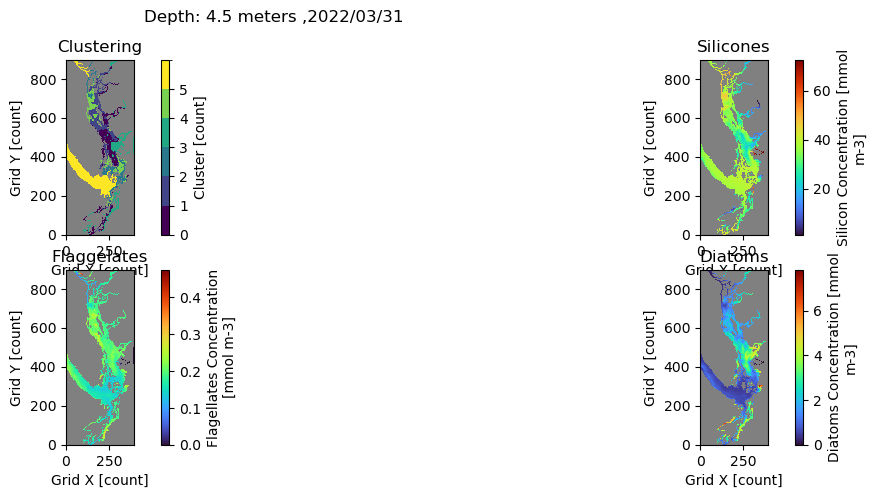

The amount of grid boxes for cluster 0 is 7223 

The minimum temperature for cluster 0 is 6.54 degrees Celsius
The maximum temperature for cluster 0 is 9.24 degrees Celsius
The mean temperature for cluster 0 is 8.15 degrees Celsius 

The minimum salinity for cluster 0 is 28.93 g/kg
The maximum salinity for cluster 0 is 29.71 g/kg
The mean salinity for cluster 0 is 29.27 g/kg 


The amount of grid boxes for cluster 1 is 16976 

The minimum temperature for cluster 1 is 7.4 degrees Celsius
The maximum temperature for cluster 1 is 10.21 degrees Celsius
The mean temperature for cluster 1 is 8.23 degrees Celsius 

The minimum salinity for cluster 1 is 27.61 g/kg
The maximum salinity for cluster 1 is 28.5 g/kg
The mean salinity for cluster 1 is 28.05 g/kg 


The amount of grid boxes for cluster 2 is 8527 

The minimum temperature for cluster 2 is 6.25 degrees Celsius
The maximum temperature for cluster 2 is 10.37 degrees Celsius
The mean temperature for cluster 2 is 8.6 degrees Celsius 

The 

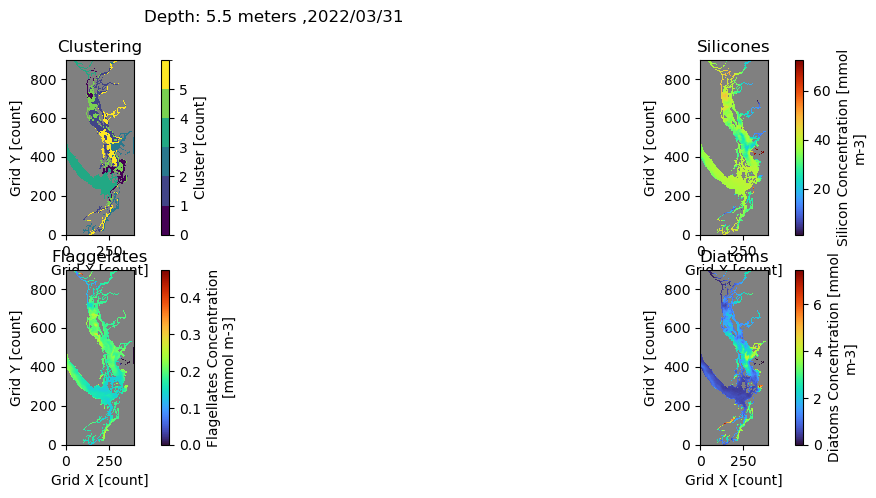

The amount of grid boxes for cluster 0 is 14760 

The minimum temperature for cluster 0 is 7.3 degrees Celsius
The maximum temperature for cluster 0 is 10.29 degrees Celsius
The mean temperature for cluster 0 is 8.33 degrees Celsius 

The minimum salinity for cluster 0 is 26.95 g/kg
The maximum salinity for cluster 0 is 27.92 g/kg
The mean salinity for cluster 0 is 27.53 g/kg 


The amount of grid boxes for cluster 1 is 13555 

The minimum temperature for cluster 1 is 7.41 degrees Celsius
The maximum temperature for cluster 1 is 8.64 degrees Celsius
The mean temperature for cluster 1 is 8.04 degrees Celsius 

The minimum salinity for cluster 1 is 27.86 g/kg
The maximum salinity for cluster 1 is 28.87 g/kg
The mean salinity for cluster 1 is 28.48 g/kg 


The amount of grid boxes for cluster 2 is 9448 

The minimum temperature for cluster 2 is 6.32 degrees Celsius
The maximum temperature for cluster 2 is 9.06 degrees Celsius
The mean temperature for cluster 2 is 8.15 degrees Celsius 

Th

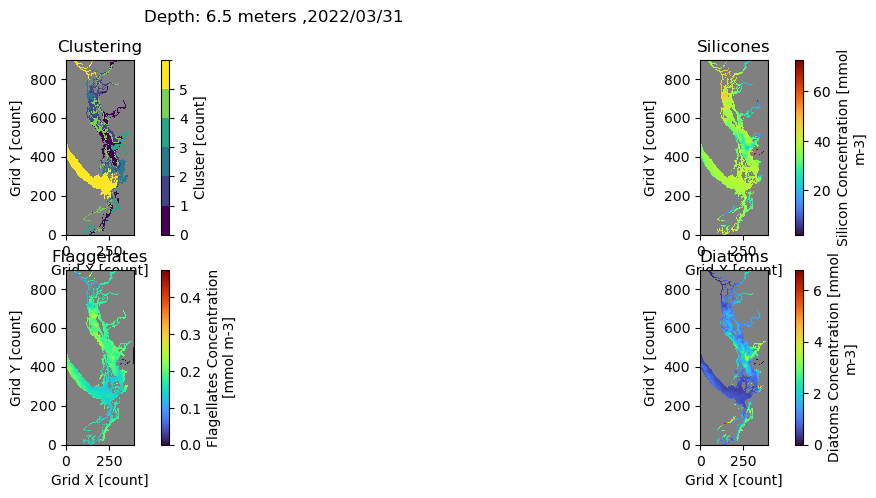

In [122]:
ds, temp, saline, date, mask, sil, flag, diat = datasets_preparation()

for depth in range (0, ds['deptht'].size+1):

    temp, saline, sil, flag, diat = masking(depth, temp, saline, mask, sil, flag, diat)
    unique, counts, inputs, predictions, clusters = som(depth, temp, saline)
    printing(inputs, predictions, unique, counts)
    plotting (depth, clusters, unique, sil, flag, diat)


<xarray.DataArray 'silicon' (time_counter: 1, deptht: 40, y: 898, x: 398)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]], dtype=float32)
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2022-03-31T12:00:00
  * deptht        (deptht) float32 0.5 1.5 2.5 3.5 ... 360.7 387.6 414.5 441.5
  * y             (y) int64 0 1 2 3 4 5 6 7 ... 890 891 892 893 894 895 896 897
  * x             (x) int64 0 1 2 3 4 5 6 7 ... 390 391 392 393 394 395 396 397
Attributes:
    standard_name:  mole_concentration_of_silicate_in_sea_water
    long_name:      Silicon Concentration
    units:          mmol m-3